In [1]:
#!/usr/bin/python

import sys
import pickle
import pandas as pd
import numpy
import time
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline
import matplotlib.pyplot as plt

/Users/benjaminxiao/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
# features_list is a list of my selected features
# all_features is a list for exploration

features_list = ['poi', 'bon_plus_expenses', 'exercised_stock_options', 
                'total_payments']
knn_list = ['poi']
all_features = ['poi', 'salary', 'bonus', 'long_term_incentive',
                'deferred_income', 'expenses', 'total_payments',
                'exercised_stock_options', 'restricted_stock', 'other', 'to_messages',
                'email_address', 'from_poi_to_this_person', 'from_messages',
                'from_this_person_to_poi', 'shared_receipt_with_poi', 'to_msg_ratio',
                'from_msg_ratio', 'bon_plus_expenses', 'bon_sal_ratio'] 

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

df = pd.DataFrame.from_records(list(data_dict.values()))
employees = pd.Series(list(data_dict.keys()))

# set the index of df to be the employees series:
df.set_index(employees, inplace=True)

In [3]:
# Create another working dataframe to make new features 
df_new = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).copy()

In [4]:
# The following are my created features

# from_msg_ratio is ratio messages received from poi to total messages received
df_new['to_msg_ratio'] = df_new.from_this_person_to_poi.divide(df_new.to_messages, axis = 'index')

# create to_msg_ratio by dividing from_this_person_to_poi from to_messages
df_new['from_msg_ratio'] = df_new.from_poi_to_this_person.divide(df_new.from_messages, axis = 'index')

# create a new feature by adding expenses and bonus together
df_new['bon_plus_expenses'] = df_new['bonus'].add(df_new['expenses'], axis = 'index')
# new feature of bonus to salary ratio

df_new['bon_sal_ratio'] = df_new['bonus'].divide(df_new['salary'], axis = 'index')
# new feature of bonus to expenses ratio

In [5]:
# Check how many missing values are in each column
print df_new.isnull().sum()

bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
email_address                146
exercised_stock_options       44
expenses                      51
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
loan_advances                142
long_term_incentive           80
other                         53
poi                            0
restricted_stock              36
restricted_stock_deferred    128
salary                        51
shared_receipt_with_poi       60
to_messages                   60
total_payments                21
total_stock_value             20
to_msg_ratio                  60
from_msg_ratio                60
bon_plus_expenses             75
bon_sal_ratio                 64
dtype: int64


In [6]:
# Fill NaN with 0 where operations created NaN in some rows
df_new.fillna(0, inplace = True)

In [7]:
# after you create features, the column names will be your new features
# create a list of column names:
new_features_list = df_new.columns.values
print new_features_list

['bonus' 'deferral_payments' 'deferred_income' 'director_fees'
 'email_address' 'exercised_stock_options' 'expenses' 'from_messages'
 'from_poi_to_this_person' 'from_this_person_to_poi' 'loan_advances'
 'long_term_incentive' 'other' 'poi' 'restricted_stock'
 'restricted_stock_deferred' 'salary' 'shared_receipt_with_poi'
 'to_messages' 'total_payments' 'total_stock_value' 'to_msg_ratio'
 'from_msg_ratio' 'bon_plus_expenses' 'bon_sal_ratio']


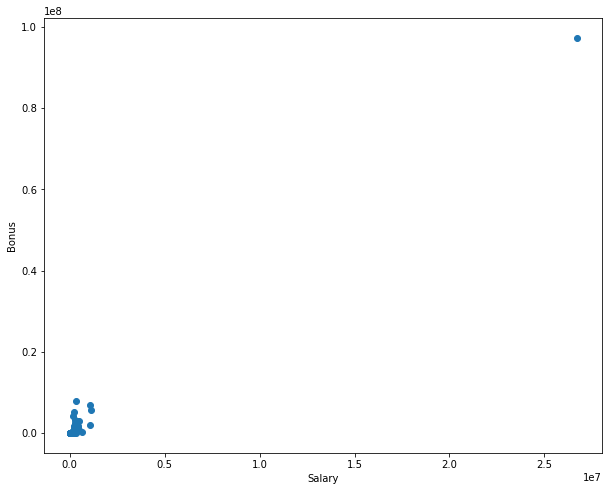

In [8]:
### Task 2: Remove outliers
# plot salary vs bonus as first step of outlier detection, visually
# uncomment the next line if using Jupyter Notebook for an inline plot
#%matplotlib inline
x = df_new['salary']
y = df_new['bonus']
plt.figure(figsize = (10, 8))
plt.scatter(x, y)
plt.xlabel('Salary')
plt.ylabel('Bonus')
plt.show()

In [9]:
print "Highest bonus value: " + str(df_new['bonus'].max())
print "Highest salary value: " + str(df_new['salary'].max())

Highest bonus value: 97343619.0
Highest salary value: 26704229.0


In [10]:
# Identify the highest bonus and salary values to see what is going on 
df_new.sort_values(['bonus', 'salary'], ascending=False).head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,to_msg_ratio,from_msg_ratio,bon_plus_expenses,bon_sal_ratio
TOTAL,97343619.0,32083396.0,-27992891.0,1398517.0,0.0,311764000.0,5235198.0,0.0,0.0,0.0,...,-7576788.0,26704229.0,0.0,0.0,309886585.0,434509511.0,0.000000,0.000000,102578817.0,3.645251
LAVORATO JOHN J,8000000.0,0.0,0.0,0.0,0.0,4158995.0,49537.0,2585.0,528.0,411.0,...,0.0,339288.0,3962.0,7259.0,10425757.0,5167144.0,0.056619,0.204255,8049537.0,23.578789
LAY KENNETH L,7000000.0,202911.0,-300000.0,0.0,0.0,34348384.0,99832.0,36.0,123.0,16.0,...,0.0,1072321.0,2411.0,4273.0,103559793.0,49110078.0,0.003744,3.416667,7099832.0,6.527896
SKILLING JEFFREY K,5600000.0,0.0,0.0,0.0,0.0,19250000.0,29336.0,108.0,88.0,30.0,...,0.0,1111258.0,2042.0,3627.0,8682716.0,26093672.0,0.008271,0.814815,5629336.0,5.039334
BELDEN TIMOTHY N,5249999.0,2144013.0,-2334434.0,0.0,0.0,953136.0,17355.0,484.0,228.0,108.0,...,0.0,213999.0,5521.0,7991.0,5501630.0,1110705.0,0.013515,0.471074,5267354.0,24.532820


In [11]:
# Check to see if this was in the data
df_new.loc['THE TRAVEL AGENCY IN THE PARK']

bonus                             0
deferral_payments                 0
deferred_income                   0
director_fees                     0
email_address                     0
exercised_stock_options           0
expenses                          0
from_messages                     0
from_poi_to_this_person           0
from_this_person_to_poi           0
loan_advances                     0
long_term_incentive               0
other                        362096
poi                           False
restricted_stock                  0
restricted_stock_deferred         0
salary                            0
shared_receipt_with_poi           0
to_messages                       0
total_payments               362096
total_stock_value                 0
to_msg_ratio                      0
from_msg_ratio                    0
bon_plus_expenses                 0
bon_sal_ratio                     0
Name: THE TRAVEL AGENCY IN THE PARK, dtype: object

In [17]:
# Find entry with all missing values

df_new[(df_new.T == 0).all()]

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,to_msg_ratio,from_msg_ratio,bon_plus_expenses,bon_sal_ratio
LOCKHART EUGENE E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
print df_new.loc['TOTAL']

bonus                        9.73436e+07
deferral_payments            3.20834e+07
deferred_income             -2.79929e+07
director_fees                1.39852e+06
email_address                          0
exercised_stock_options      3.11764e+08
expenses                      5.2352e+06
from_messages                          0
from_poi_to_this_person                0
from_this_person_to_poi                0
loan_advances                 8.3925e+07
long_term_incentive          4.85219e+07
other                        4.26676e+07
poi                                False
restricted_stock             1.30322e+08
restricted_stock_deferred   -7.57679e+06
salary                       2.67042e+07
shared_receipt_with_poi                0
to_messages                            0
total_payments               3.09887e+08
total_stock_value             4.3451e+08
to_msg_ratio                           0
from_msg_ratio                         0
bon_plus_expenses            1.02579e+08
bon_sal_ratio   

In [18]:
# Removed row "TOTAL" because it's not a proper data point, as in it's not an employee
df_new.drop([['TOTAL', 'THE TRAVEL AGENCY IN THE PARK']], inplace=True)

TypeError: unhashable type: 'list'

In [ ]:
# Find how many POIs are left in the data
print "Number of POI in data set: " + str(len(df_new[(df_new['poi'] == True)]))

In [ ]:
# create a dictionary from the dataframe
df_dict = df_new.to_dict('index')

In [ ]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = df_dict

In [ ]:
# Check how many data points are left in my data
print "Number of data points: " + str(len(my_dataset))

In [ ]:
### Extract features and labels from dataset for local testing
# Created one function for exploration then another for use after feature selection
exploration_data = featureFormat(my_dataset, all_features, sort_keys = True)
labels_exploration, features_exploration = targetFeatureSplit(exploration_data)

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [ ]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.

In [ ]:
selection = SelectKBest(k = 3)
selection.fit(features_exploration, labels_exploration)
print selection.scores_

In [ ]:
# Pipeline with KNearestNeighbors, first scaling with StandardScaler
# PCA is to help with KNN performance

knn = make_pipeline(StandardScaler(with_std = True), 
                    SelectKBest(),
                    KNeighborsClassifier())
knn.fit(features_exploration, labels_exploration)

In [ ]:
# First one tried is RandomForestClassifier
rfc_exploration = RandomForestClassifier()
rfc_exploration = rfc_exploration.fit(features_exploration, labels_exploration)

In [ ]:
# Also trying a decision tree classifier because tree classifiers make sense here
dc_exploration = DecisionTreeClassifier()
dc_exploration= dc_exploration.fit(features_exploration, labels_exploration)

In [ ]:
# This function appends the feature and according importance value from tree
# classifier to a list to view more neatly
rfc_impt = []
dc_impt = []
selection_scores = []

def input_impt(impt_list, features_list, impts):
    for i in range(len(impts)):
        impt_list.append( (features_list[i], impts[i]) )
    
    impt_list.sort(key = lambda tup: tup[1], reverse = True)
    
    return impt_list

In [ ]:
# Call previous function to append and sort feature importances 
input_impt(rfc_impt, all_features[1:], rfc_exploration.feature_importances_)
input_impt(dc_impt, all_features[1:], dc_exploration.feature_importances_)
input_impt(selection_scores, all_features[1:], selection.scores_)

In [ ]:
print "RandomForestClassifier importances values: "
for item in rfc_impt:
    print item[0] + " : " + str(item[1])

In [ ]:
print "DecisionTreeClassifier importances values: "
for item in dc_impt:
    print item[0] + " : " + str(item[1])

In [ ]:
print "SelectKBest scores: "
for item in selection_scores:
    print item[0] + " : " + str(item[1])

In [ ]:
# Assign to new classifiers after choosing features

rfc = rfc_exploration.fit(features, labels)
dc = dc_exploration.fit(features, labels)

In [ ]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info:
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [ ]:
# straified cv for parameters, 100 fold, and shuffled
best_cv = StratifiedShuffleSplit(n_splits = 100, random_state=42) 

In [ ]:
# Function for entering classifiers into GridSearchCV with respective param_grids
# The output is time elapsed to run GridSearchCV and best_params_

def gridcv(clf, param_grid, cv, n_jobs, scoring):
    start_time = time.time()
    grid_cv = GridSearchCV(estimator = clf, param_grid = param_grid, cv = cv, 
                          n_jobs = n_jobs, scoring = scoring)
    grid_cv.fit(features, labels)
    end_time = time.time()
    print "Minutes elapsed: " + str((float(end_time - start_time) / 60))
    print grid_cv.best_params_

In [ ]:
# Parameter grid for RandomForestClassifier
# random_state parameter is to maintain consistency in output.

rfc_param_grid = {'n_estimators': [1,2, 3, 10, 100], 
                 'min_samples_split': [2, 3, 5],
                'random_state': [42],
                 'max_features': [1, 2, 3],
                 'max_depth' : [2, 3, 5, 10, 50],
                 'min_samples_leaf': [1, 2, 3, 10]
                 }

In [ ]:
# gridsearchcv parameter grid for decisiontreeclassifier
# The list comprehension for max_features is just to make the feature selection
# process easier on me.
dc_param_grid = {'min_samples_split' : [2, 3, 4, 5, 10, 50],
                 'max_features' : [x for x in range(1, len(features_list))],
                 'min_samples_leaf': [1, 2, 3, 10, 20],
                'random_state' : [42]
                }

In [ ]:
# gridsearchcv parameter grid for KNeighborsClassifier
knn_param_grid = {'kneighborsclassifier__n_neighbors': [x for x in range(1, len(features_list))],
                  'kneighborsclassifier__algorithm': ['auto'],
                  'kneighborsclassifier__p': [1, 2],
                  'kneighborsclassifier__weights': ['uniform', 'distance'],
                  'selectkbest__k': [x for x in range(1, len(features_list))]
                 }

In [ ]:
# It took 94 minutes for me to run GridSearchCV for RandomForestClassifier.
#gridcv(rfc, rfc_param_grid, best_cv, 5, 'f1')

In [ ]:
# Assign clf to classifer chosen after testing with tester.py
# Parameters are selected from GridSearchCV's best_params_ attribute

#clf = RandomForestClassifier(min_samples_split = 2, n_estimators = 3,
#                            random_state = 42, max_depth = 50, min_samples_leaf = 1,
#                            max_features = 3)
#clf.fit(features, labels)

In [ ]:
gridcv(dc, dc_param_grid, best_cv, 5, 'f1')

In [ ]:
# Parameters are selected from GridSearchCV's best_params_ attributes
# I ended up choosing DecisionTreeClassifier because it performed better with
# precision and recall in tester.py
clf = DecisionTreeClassifier(min_samples_split = 2, random_state = 42,
                            max_features = 2, min_samples_leaf = 1)
clf.fit(features, labels)

In [ ]:
# Run GridSearchCV for KNeighborsClassifier parameters
gridcv(knn, knn_param_grid, best_cv, 5, 'f1')

In [ ]:
# Assign KNeighborsClassifier to clf for testing

#clf = make_pipeline(StandardScaler(with_std = True), 
#                    SelectKBest(k = 3),
#                    KNeighborsClassifier(n_neighbors = 1, algorithm = 'auto', 
#                                        weights = 'uniform',p = 2))
#clf.fit(features_exploration, labels_exploration)

In [ ]:
# This little bit of code is a quick preliminary check before running tester.py
labels_pred = clf.predict(features_test)
f1_score(labels_test, labels_pred)

In [ ]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)
